# Fitting with Radial Basis Functions (8 points)




## Please read carefully; these rules apply to parts 1 and 2 of the project:

### Due date is posted on Canvas. Projects are accepted late with a 15% per day penalty, pro-rated hourly. If you are 30 hours late, your penalty is (30/24)*15%. 

### If you submit Part 1 on time and are late on Part 2, then the late penalty would only apply to Part 2. Fair enough?

### Honor code: 
* You can ask general questions on Piazza
* If your notebook is hung up for some reason, you can defintely let us know on Piazza. 
* You can ask specific questions only in a breakout room during office hours
* Do not post any code, answers, or images on Piazza. 
* Do not work with other human beings with the exception of an IA, GSI, or professor of the course. 
* By submitting this project, you are attesting that it represents your own work and not the work of anyone else, with the excpetion of any assistance provided in office hours by an IA, GSI, or professor of ROB 101. 

### We use an autograder to check your work. If you invent new notation (such as, new variable names) for yourself, you will mess up the autograder and receive no points. We will NOT do manual re-grades because of failure to use the requested variable names

### If you change the name of this file, it will not be graded by the autograder and we will not do a manual grade of your work in a different notebook.

### Hit save periodically while working in this notebook. You can submit multiple times because we only grade the last submission. 

# For best results, when submitting your FINAL notebook, use the ```Restart Kernel & Clear Output``` option above. When the autograder is run, it re-runs all cells from scratch. By clearing your outputs, you erase the (often large) plots in the output too, which makes the file super compact. All of your code remains intact. We promise! For intermediate submissions, you can just hit submit, without clearing your outputs. And if on the final submit you forget to clear your outputs, it should be fine... 

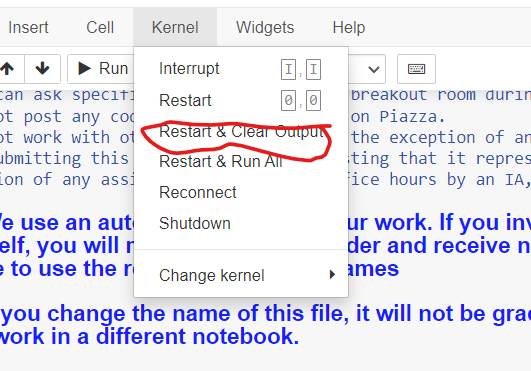




## Introduction

In HW and lecture, you used linear regression to fit monomials, a set of nonlinear basis functions, to a set of points in 3D (surface regression). In Project 2, we will explore a special nonlinear basis called the **radial basis functions** and see how these functions can be used to better fit a surface to a set of ponts. If you have heard of Machine Learning, a popular form of AI, then you'll be happy to know that radial basis functions are very common in Supervised Machine Learning!

**Note:** As you walk through the notebook, if there is a cell that contains code or a step that you don't quite understand, feel free to create a new block right below the cell and type $\texttt{@show}$ $\texttt{variable_name}$ to display the contents of the variable. This can help to expose some of the intermediate steps.

## Before we move on. Here are some quick questions that are here based on past stumbling blocks with Project 2:

1. Have you read the Project 2 PDF (https://umich.instructure.com/courses/555306/files/folder/Project%20Background%20Files), noted the warning(s) given in the document, **AND noted that you can check your final results for Part 2 of Project 2 by looking at the last figure in the document?** 

2. Suppose that A x = b is an overdetermined system of linear equations. Have you reviewed in Chapter 8 how to compute a least squared error solution when the columns of A are linearly indepdendent?

3. Do you understand that this is the recommended LU Pipeline for solving Regression Problems in ROB 101? 
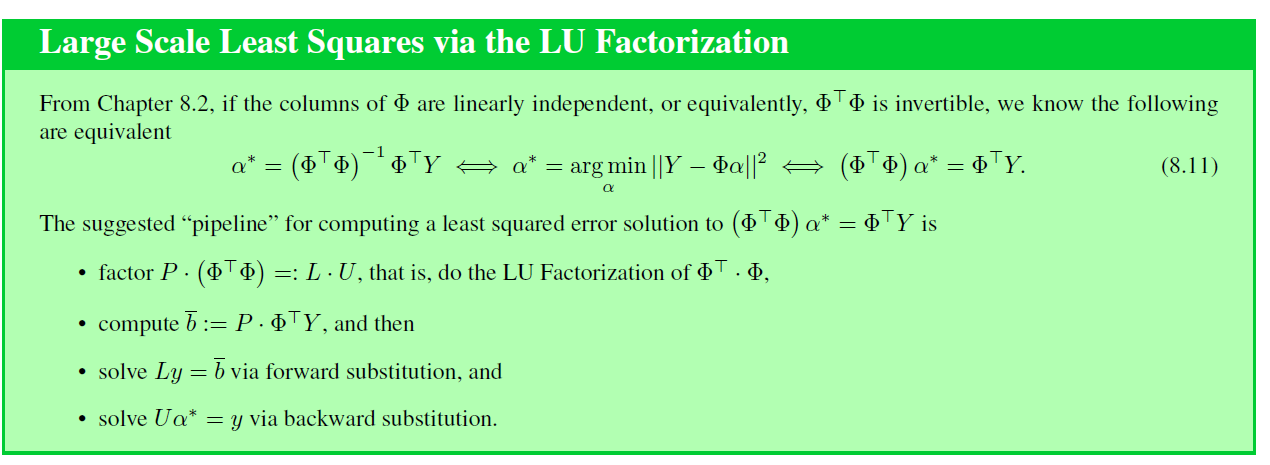

4. **Part 2 of Project 2 is a vector version of Part 1.** In fact, Part 1 is a tutorial for completing a realistic project, such as Part 2. 

In [ ]:
# My answer to each of the above questions is: Replace ?? in line three with a 
# single true or a single false 
# answer = ??

In [ ]:
# Friendly check 
if answer == true
    println("You are ready to start the project.")
else
    println("Ooops! We'll let you continue, but you risk being frustrated.")
end
    

In [ ]:
using Plots, LaTeXStrings, LinearAlgebra, Random
gr()
default(
    titlefont = (16, "times"), 
    legendfontsize = 12, 
    guidefont = (14), # Changes x and y axis label fonts
    linewidth = 2)

To build up intuition for some of the properties of the radial basis function, let's first explore trying to fit a curve to "noisy" measurements corresponding to a real-valued function. We will generate realistic measurements by selecting points on the x axis and adding "noise" (that is, random numbers) to the corresponding output value of the function. If this is abstract, you can think of the y values of the function as temperature values, the x values as the measurement time and the noise as the measurement error that is inherent to our specific sensor.

Create a new cell block and type ``?randn`` to find out more about the noise being added. 

In [ ]:
# Run me, don't change me. I will generate a plot for you. 
#
# Create a known function with no noise

x_actual = collect(1:0.01:2.5);
y_actual = cos.(2π * x_actual) .* exp.(-x_actual);
plot(x_actual, y_actual, title=L"$f(x) = e^{-x}cos(2\pi x)$", legend=false)
xlabel!(L"x")
ylabel!(L"f(x)")

## In the cell below

1. the vector **x_measured** will be used when building your regressor matrix, which we often called $\Phi$ in the textbook.


2. the vector **y_measured** was often called $Y$ in the textbook.

In [ ]:
# Run me, don't change me. I will generate the following for you:
#     - x_measured a vector of real numbers of points where the function is "measured"
#     - y_measured a vector of real numbers of points corresponding to "noisy" measurements
#     - A plot with our function + the points we sampled from it with noise

# Randomly sample N points along the x axis
N = 50

# Allows us to get the same random numbers every time we run this cell
Random.seed!(12345678)

# We use unique because after flooring the numbers (rounding numbers to the nearest 
# integer less than or equal to the number), we may have repeated indices
idx = Int.(unique(floor.(rand(N) * length(x_actual))) .+ 1) # random indices
N   = length(idx);

x_measured = x_actual[idx]; # Training input

# Noise from a scaled normal distribution
y_measured = y_actual[idx] + 0.02 * randn(N)

println("Each of the yellow dots is a measurement that we will 
    use for building an approximation of the function f(x) ")

plot(x_actual, y_actual, title="Noisy measurements from a known function",
    label=L"$f(x) = e^{-x}cos(2\pi x)$", xlabel=L"$x$", ylabel=L"$f(x)$")
scatter!(
    x_measured, 
    y_measured, 
    c=:orange, # set the color
    label="Noisy Measurements", 
    legend=:best) # automatically use best location to place legend in graph


### Now imagine that we were given the indicated noisy measurements (yellow dots) and we would like to fit a function to them. Here, in this toy example, we know what the function is, but in practice, all we know are the measured values! How can we go about finding a function that explains the data?

## Let's start with trying to use a basis often used in the textbook, namely monomials (powers of x). Remember that the basis functions can themselves be nonlinear. It is only the way that we combine the functions together that needs to be linear (a linear combination).

## Your objective:

Find a set of coefficients $a_1$, $a_2$, $a_3$, $a_4$ such that for every measured point $x_i$, our model produces a prediction or output as close to the actual $y_i$ value as possible. The error between our model prediction and our actual value is $e_i = y_i - \hat{y}_i$.

$$\hat{y} = a_1 + a_2 x + a_3 x^2 + a_4 x^3 $$

We refer to our coefficients collectively as $a_{star} = [a_1, a_2, a_3, a_4]$. As we will see in the next couple of cells, the use of monomials as basis functions will not be a great design choice here. However, we use them for the purpose of illustrating the added value of radial basis functions. 

## Task 1: Construct a Regressor Matrix (3 points)

With the model described above, we can form a set of linear equations where each equation is formed by evaluating the $x_i$ value of our measurement to obtain a predicted $\hat{y}_i$ value.

\begin{align*}
\hat{y}_1 &= a_1 + a_2x_1 + a_3x_1^2 + a_4x_1^3 \\
\hat{y}_2 &= a_1 + a_2x_2 + a_3x_2^2 + a_4x_2^3 \\
&~~\vdots \\
\hat{y}_k &= a_1 + a_2x_k + a_3x_k^2 + a_4x_k^3 \\
&~~ \vdots \\
\hat{y}_N &= a_1 + a_2x_N + a_3x_N^2 + a_4x_N^3
\end{align*}

With our linear equations written out, we can now write the set of linear equations succinctly as $\hat{Y} = \Phi a$. 

## For Task 1, you will compose the code necessary to construct the regressor matrix  $\Phi$ for our assumed model. __Hint:__ Since our model has 4 coefficients, the size of $\Phi$ will be N x 4 where N is the number of measurements we have taken. 

## We first remind you how in lecture we constructed the regressor matrix $\Phi$ column-by-column and then we have you do it row-by-row. Both methods are common in engineering practice.

In [ ]:
# Run me and note the size of x_measured
length(x_measured)

In [ ]:
# In HW, Lab, and Lecture, we have usually constructed the regressor matrix columnwise, 
# as follows
#
# monomial basis elements = [1 x x² x³]
N = length(x_measured)
# regressor matrix by columns
Phi_example=[ones(N,1) x_measured x_measured.^2 x_measured.^3]
#

In [ ]:
# For the project, we want you to build the regressor matrix row-by-row. 
# You will need a single for loop 
# The monomial basis is still [1 x x² x³]

N=length(x_measured)
Phi=zeros(N,4)

#
# Write a for loop that builds the regressor matrix ROW by ROW.
# 
# We emphasize, ROW by ROW and NOT Column by Column.
#
# There should be N rows, where N is defined above.
# Once again, use a for loop
#
# YOUR CODE HERE



In [ ]:
# friendly check
# if the value of is_it_correct_checkN is "Yes", then your answer may be correct. 
# If the value of is_it_correct_checkN is "No", then your answer is wrong

is_it_correct_check1 = (norm(Phi-Phi_example) < 1e-6) ? "Yes" : "No" 

@show is_it_correct_check1;

In [ ]:
# Run me, don't change me. I will create a forward substitution function and a backward substitution function 
# that you can apply to systems of linear equations arising from an LU Factorization

#=
forwardsub(L, b)

It solves for x in an equation Lx = b, where L is lower triangular.
=#


function forwardsub(L, b)
    # When L comes from an LU Factorization, the elements 
    # on its diagonal are all ones.
    # START of our computations
    n = length(b)
    x = Vector{Float64}(undef, n); #initialize an x vector of the correct size
    x[1] = b[1]/L[1,1] #find the first entry of x
    for i = 2:n #find every entry from the 2nd to the end
        x[i] = (b[i]- (L[i,1:i-1])'*x[1:i-1] )/L[i,i] 
        #notice that we used the transpose operator to get the row of L
    end
    # END of our computations. 
    return x
end

# Run me, don't change me. I will create a back substitution function that you can apply
# to systems of linear equations with an upper triangular "A" matrix, that we denote by U

#=
backwardsub(U, b)

It solves for x in an equation Ux = b, where U is upper triangular.
=#

function backwardsub(U, b)
    # U could have zeros on its diagonal. We check for that
    # Assert no entries in the diagonal of U
    # are 0 (or very close to 0)
    if minimum(abs.(diag(U))) < 1e-6
        println(" U is nearly singular. ")
        return x = NaN
    end
    
    n = length(b)
    x = Vector{Float64}(undef, n)
    x[n] = b[n] / U[n,n]
    for i = n-1:-1:1
        x[i] = (b[i] - (U[i,(i+1):n])' * x[(i+1):n]) / U[i,i]
    end
    
    return x    
end

## Least Squares LU Pipeline (1 point)  

### Follow this pipeline to solve least squares problems using LU factorization. You can find more details, if you need them, in Chapter 8 of our textbook! 

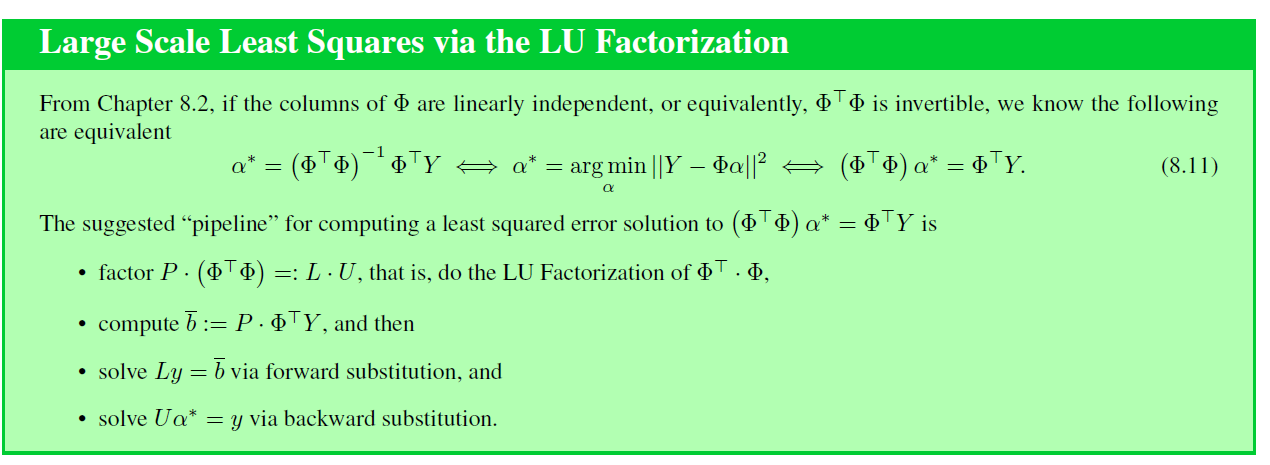

### To efficiently solve for x in the LU pipeline, two cells above, we gave you functions for backward and forward subtitution, the same as we have used in homeworks! The LU Factorization part is left to you. The textbook and lab manual both show how to use Julia's LU Factorization correctly.

## Build a function that uses the above LU pipleline to solve a regression problem for $$ \Phi \alpha^\ast = Y.$$ You can assume the columns of $\Phi$ are linearly independent. You NEED TO ASSUME that you are carrying out LU-factorization with permutations. We empasize that you are solving for $$\alpha^\ast := \underset{\alpha}{\rm arg~min} ||Y-\Phi \alpha ||^2.  $$

In [ ]:
# Use the template below, where the returned variables is alphaStar = α*
# from the big green box! 

# Phi::Array{Float64,2} simply checks that the input is a real matrix
# Y::Array{Float64,1} simply checks that the input is a real vector 

function least_squares_lu(Phi::Array{Float64,2},  Y::Array{Float64,1})
    # Phi is matrix of real numbers with lin. indep. columns
    # Y is a column vector
    # size(Phi,1) == length(Y)
    
    # YOUR CODE HERE
    
    return alphaStar
end 

In [ ]:
# friendly check
# if the value of is_it_correct_checkN is "Yes", then your answer may be correct. 
# If the value of is_it_correct_checkN is "No", then your answer is wrong

PhiTest = [ 1 1.0; 1 2; 1 4; 1 5]
YTest = [2; 3.2; 4.7; 6]
alphaStarTest=least_squares_lu(PhiTest,YTest)
display(alphaStarTest)
is_it_correct_check1 = (norm(alphaStarTest- [1.125000000000001;  0.9499999999999996]) < 1e-4) ? "Yes" : "No" 

@show is_it_correct_check1;

## In the next cell, we next use your function least_squares_lu to solve for a_star

In [ ]:

a_star = least_squares_lu(Phi,y_measured)

# Let's see the cofficients for our monomial fit model 
@show a1 = a_star[1];
@show a2 = a_star[2];
@show a3 = a_star[3];
@show a4 = a_star[4];
@show a_monomial = copy(a_star)

In [ ]:
# Autograder cell, just checking if you ran everything fine 
a_monomial = copy(a_star)
@assert isapprox(a_monomial, [11.914460345663601, -21.29385582440765, 12.222600209006371, -2.2639072928600648], atol = 0.001)

## Let's now use your regressed coefficients a_star to build a scalar-valued (i.e., not a vector) function based on the monomials, $1, x, x^2, x^3$. 

## Reminder: You are fitting a function to data. Hence, the result of your regression work with monomials is a polynomial approximation to our data set.


In [ ]:
# Build a function based on your regressed monomial coefficients.
# Your function only needs to work for x a scalar value
#
# Hint, later in the notebook, the problem is essentially solved for you!
#
function yHatMonomials(x,a=a_star)
    # x is a scalar value (real number)
    # a is a vector of parameters for the polynomial
    # yHat is the polynomial approximation to the data at the point x
    
    # YOUR CODE HERE
    
    return yHat    
end

In [ ]:
a_star

In [ ]:
# friendly check
# if the value of is_it_correct_checkN is "Yes", then your answer may be correct. 
# If the value of is_it_correct_checkN is "No", then your answer is wrong

is_it_correct_check1 = ((yHatMonomials(-1) - 47.694823671937684) < 1e-5) ? "Yes" : "No" 
is_it_correct_check2 = ((yHatMonomials(2) - 0.1058911899932653) < 1e-5) ? "Yes" : "No" 
is_it_correct_check3 = (norm(yHatMonomials.([1; 2]) -[0.579297437402257; 0.1058911899932653]) < 1e-5) ? "Yes" : "No" 

@show is_it_correct_check1;
@show is_it_correct_check2;
@show is_it_correct_check3;

## Finally, now that we have our weights for the monomial basis elements, let's check the quality of our fit. A way to quantify how well our model fits the data is to calculate the total squared fitting error. We will calculate our error by comparing how well our model predicts the values we MEASURED and not the TRUE VALUES from the original function (remember, we wouldn't know the actual function in practice). 

### We define the fitting error $E_{tot}$ below where $y_i$ is the true value obtained from our known function at $x_i$, and $\hat{y}_i$ is the ouput of our model after evaluating it at $x_i$. 

### $$E_{tot} = \sum_{i=1}^{N}(e_i)^2 = e^\intercal e = (\hat{y} - y)^\intercal(\hat{y} - y) = ||\hat{y} - y||^2_2$$


### The next cell provides us a small helper function to calculate this error.

In [ ]:
# Run me, don't change me! I create a function that
# helps to calculate the fitting error of our
# monomial model

#=
error_monomial_fit(a, X)

Calculates and returns the error E_tot defined as:

            E_tot = Σ(yhat_i - y_i)^2

between the monomial model and the actual function
=#
function error_monomial_fit(X, a=a_star, y=y_measured)
    # This function accepts X as a column vector
    # Default values are provided for the coefficients a and mesurements y
    
    @assert size(a,1) == 4
    
    # Calculate the value of the model: y_hat = a₁ + a₂x + a₃x^2 + a₄x^3
    # We vectorize the computations
    y_hat = a[1] .+ a[2]*X + a[3]*X.^2 + a[4]*X.^3

    # Return the total squared error E_tot
    return (y - y_hat)' * (y - y_hat)
end

In [ ]:
# Run me, don't change me! We illustrate here how to generate 
# a plot of the estimated function and report the fitting error.
#
# We use the same x points we used for drawing our original 
# function to draw our regressed function

y_hat = yHatMonomials.(x_actual) # the . after yHatMonomials applies the function to each 
                                # component of x_actual; see broadcasting in the Lab Manual

# Calculate and display the fitting error
etot = error_monomial_fit(x_measured)
println("The monomial fitting error  $etot  is not very good. We will work to fix this.")
println("The blue line is our polynomial fit while the orange dots are the data.")

plot(x_actual, y_hat, label="monomial model", xlabel=L"$x$")
plot!(x_actual, y_actual, label="actual function")
scatter!(x_measured, y_measured, c=:orange, label="Noisy Measurements", 
    legend=:best, size=(800,500))

### While the general shape is roughly captured, the crests in the plot do not match well and we can see that, if we were to extend the x axis in either direction, the two curves would diverge significantly. 

## The source of the problem is the use of the monomials, which, being powers of x, blow up as x gets large. The monomial basis often turns out to be quite incovenient when doing regression problems.

### Let's plot the monomial functions individually and get a feel for them. As you move through the notebook, the goal will be to arrive at a model that will produce a lower fitting error than the one above based on monomials.

In [ ]:
#Run me, don't change me !
#
# I create two plots. The first plot shows a line for each of the 4 monomials 
# in our model. The second plot shows a picture of x^2 to use as a reference.

l = @layout [a{0.7w} b{0.3w}]
p1 = plot(x_actual, a1*ones(length(x_actual)), label=L"$\phi_1(x) = a_1$")
plot!(p1, x_actual, a2*x_actual, label=L"$\phi_2(x) = a_2 x$")
plot!(p1, x_actual, a3*x_actual.^2, label=L"$\phi_3(x) = a_3 x^2$")
plot!(p1, x_actual, a4*x_actual.^3, label=L"$\phi_4(x) = a_4 x^3$",
    legend=:outertopright)
xlabel!(L"$x$")
title!("Basis Functions")

x_sq = collect(-1:0.01:1)
p2 = plot(x_sq, x_sq.^2, label=L"x^2",color=:green)
xlabel!(L"$x$")
plot(p1, p2, layout=l, size=(800,400))

What are some things you might notice about each of the individual monimals you've plotted? If someone asked you to describe the shape of the $x^2$ you might say that it is bowl shaped, as shown to the right. However, in the image to the left, we see only a portion of a _really_ big bowl. One of the issues of using the monomial basis functions is that if we take $x^2$ for example, regression tries to fit it to all the measurements. What if we could have it just fit ONLY the measurements near the bowl shape at $x$=1.5 in the orignal (actual) function. **Said another way, what if we could locally fit the basis functions to individual sections of the data?**


## The Radial Basis Function


$$f(x; x_c, s) = exp(\frac{-|x-x_c|^2}{2s^2})$$

The equation above is the formula for a generic Radial Basis Function (RBF). $x$ and $x_c$  are vectors in $\mathbb{R}^n$ and $s$ is a positive scalar. Both $x_c$ and s are known before evaluating the function and are said to parameterize the function. Just as $y=2x$ and y=$-3x$ are both equations for lines but the value of the slope changes the steepness of the line, we will find that our radial basis function always has a bell-shaped curve that changes its look based on the values of $x_c$ and $s$. In particular, $x_c$ determines the **center** of the function and s determines its **width**.

In [ ]:
# For this cell, try out different values for each of the
# three variables listed below with the suggested range for 
# each variable in the comments. The cell will display the 
# RBF function.

## EDIT ##
x1 = 0  # Try values between [-5, 5]
xc = 0  # Try values between [-5, 5]
s = 1   # Try values between [0.1, 2]
## EDIT

# rbf(x) assumes x, xc and s are all scalars (real numbers)
rbf(x, xc, s) = exp(-(x-xc)^2 / (2*s^2))

# The radial basis function, vectorized!
# For x a column vector, xc a scalar, and s a scalar, the function
# rbfVectorized returns a column vector of the same size as x
# We will use it in some of our plots
rbfVectorized(x, xc, s) = exp.(-(x.-xc).^2 / (2*s^2))

x = collect(-5:0.1:5) .+ xc
y = rbfVectorized(x, xc, s) 
    
plot(x, y, xlabel=L"$x$", label="\$f(x_1;x_c=0,s=$s)\$",
    title="Radial Basis Function", xlims=(-10,10))
plot!([x1], [rbfVectorized(x1, xc, s)], marker=:orange, markersize=5, 
    label=L"$x_1$", legend=:outertopright, size=(800,500))

Take a few minutes to understand how changing each input to the function affects its graph. As you play around with the inputs you should notice the following:

* $x$: as $x$ gets further and further in either direction away from $x_c$, the value of the function becomes smaller. It is the largest when $x$ is exactly $x_c$. This makes sense because when we look at the numerator in the exponent of our RBF, $|x-x_c|^2$ just represents the norm (distance) between two vectors. However, because we are negating the power in the function ($\exp(-...)$), large norms lead to small ouptut values.

* $x_c$: changes where the peak of the bell curve lies. We can think of this as the function's center.

* $s$: changes how narrow or wide our function is


## Task 2: Using Radial Basis Functions  (RBFs) (2+2 points)

## Part A: Fitting By Hand on RBFs (2 points)

In the last set of cells, we looked at how the inputs of the RBF change the shape of the function. In this task, we explore trying to fit our original real-valued function $f(x) = e^{-x}cos(2\pi x)$ with two RBFs and a constant. We can write our model as follows:

$$\hat{y} = a_0 + a_1 f(x; x_{c_1}, s) + a_2 f(x; x_{c_2}, s)$$

Note that in this formulation, the width parameter $s$ is shared between both RBFs. Typically, when using RBFs, there will be one width parameter shared among all of the basis functions. For the rest of this project, we will do so as well. In the next two cells, we provide two helper functions to plot our model and calculate the fitting error with our two-RBF model.


In [ ]:
# Run me, don't change me. I will create a function
# that will plot our 2 RBF models along with our
# original function using the parameters provided

function plot_2rbf_model(f)    
    # Calculate the value of the model: y_hat = a₁f(x; xc1, s) + a₂f(x; xc2, s)
    # at each data point val in x_actual and arrange it as a vector
     y_hat = f(x_actual)    
     plot(x_actual, y_actual, title="Partial Data Fit", line=:dash,
        label=L"$f(x) = e^{-x}cos(2\pi x)$", xlabel=L"$x$", ylabel=L"$f(x)$", c=:orange)
    plot!(x_actual, y_hat, label="\$$a0 + $a1 f(x_1;x_c=$xc1,s=$s) + $a2 f(x;x_c=$xc2,s=$s)\$", c=:blue)
    scatter!(x_measured, y_measured, c=:orange, label="Noisy Measurements", 
        legend=:best, size=(800,500)) 
end

In [ ]:
# Run me, don't change me. I will create a function
# that will calculate the total error between our
# model predicted values and the actual measurements

#=
error_2rbf_fit(a1, xc1, a2, xc2, s, x)

Calculates and returns the error E_tot defined as:

            E_tot = Σ(yhat_i - y_i)^2

when x is a vector
=#

function error_2rbf_fit(a0, a1, xc1, a2, xc2, s, x)
    
    # Calculate the value of the model: y_hat = a₁f(x; xc1, s) + a₂f(x; xc2, s)
    # at each data point val in x and arrange it as a vector
    y_hat = [a0 + a1 * rbf(xval, xc1, s) + a2 * rbf(xval, xc2, s) for xval in x]
    # the "for xval in x" creates y_hat as a column vector (N x 1 matrix)
    # where N = length(x). 
    return (y_measured - y_hat)' * (y_measured - y_hat)
end

For this task, you will tune by hand 5 parameters to minimize the fitting error $E_{tot}$ of our model. The parameters $a_1$ and $a_2$ are the coefficients of our model, $xc1$ and $xc2$ are the centers of our RBFs and $s$ is the shared width parameter. The constant term/bias is set to $a_0 = 0.05$.

## Because we are only using two RBFs and are tuning the parameters by hand, our modest goal is to identify a parameter set that produces a total error that is less that 0.5.

To start off, it is suggested to fit one RBF at a time. Set the coefficient $a_2$ to 0 if it is not 0 by default and adjust the parameters $a_1$, $xc1$, $s$ to approximately fit one of the two humps in the function. Once that's done, begin to modify $a_2$ and $xc2$. As you start fitting the second RBF, you may want to revisit some of your values for $s$, $a_1$, and $xc2$.

#### Hint: s = 0.15 is the value we used. You are encouraged to play around with the width paramters s to see what it does.

In [ ]:
# Modify this cell. In this cell you will tune the values in
# the edit section to fit two RBFs to our original function
# Each time you run this cell will plot the model defined
# by the parameters as well as display the fitting error

# ######     EDIT     ######
# a1  = 1  # Try values in between [-1, 1] 
# xc1 = 1.75  # Try values in between [1, 2.5]
# s   = 0.15  # Try values in between [0, 0.3]
# xc2 = 1.75  # Try values in between [1, 2.5]
# a2  = 0    # Try values in between [-1, 1]
# a0 = 0.05  # Don't change this value. We already tuned it for you! 
# ######     EDIT     ######

# Display error
etot_2rbf = error_2rbf_fit(a0, a1, xc1, a2, xc2, s, x_measured)
etot_monomials = error_monomial_fit(x_measured,a_monomial)
println("Monomial Fitting Error: ", etot_monomials)
println("2 RBF Fitting Error   : ", etot_2rbf)
println(" ")
if etot_2rbf < 0.5
    println("Good enough! You pass the test! It is not worth achieving a lower error by hand.")
else
    println("Keep trying. Be systematic on how you go about adjusting the values a1 xc1 s a2 xc2")
end

# Plot model
y_rbf(x) = [a0 .+ a1 * rbfVectorized(x, xc1, s) .+ a2 * rbfVectorized(x, xc2, s)]
plot_2rbf_model(y_rbf)

### Congratulations! You have just fit using RBFs and we hope you can see that with just two bases that we are already getting a significantly better fit in the middle portion of the x-axis. 

### At the moment, with just two basis, the total fitting error is still many times larger due to the deviation at the tails, but as we add more basis we can begin to get a closer fit at the ends of the function as well. A lot of the magic of the fit comes from the fact that values evaluated far away from the center of a RBF are very close to 0. This makes RBFs very nice to use in our linear model. 

### However, you still may have needed to have gone back and adjusted the parameters of the first RBF once you started adjusting the parameters of the second. Now that we have an understanding of the benefits of using RBFs for fitting, let's see if we can use our least squares pipeline to find a model and a set of coefficients that has a lower fitting error than our monomial model.


## Part B: Fitting using Least Squares and RBFs (2 points)


To start using more RBFs in our model, let's first expand our model and also add back the constant term. M represents the number of RBFs we decide to use in our model.

$$\hat{y} = a_1 + a_2 f(x; x_{c_1}, s) + a_3 f(x; x_{c_2}, s) + ... + a_{M+1} f(x; x_{c_M}, s)$$

Looking back up top to the least squares LU factorization pipeline, the first step we need to do is construct the regressor matrix ($\Phi$). When using the monomials, $\Phi$ looked like so:

$$
\begin{equation} \label{eq:monomial_mat_form}
    \underbrace{
    \begin{bmatrix}
    \hat{y}_1 \\
    \hat{y}_2 \\
    \vdots \\
    \hat{y}_N
    \end{bmatrix}}_{\hat{Y}}
    =
    \underbrace{
    \begin{bmatrix}
    1 & x_1 & x_1^2 & x_1^3 \\
    1 & x_2 & x_2^2 & x_2^3 \\
    \vdots & \vdots & \vdots & \vdots \\
    1 & x_N & x_N^2 & x_N^3
    \end{bmatrix}}_{\Phi}
    \underbrace{
    \begin{bmatrix}
    a_1 \\
    a_2 \\
    a_3 \\
    a_4
    \end{bmatrix}}_{\alpha}
\end{equation}
$$

With our RBFs, a single row in our $\Phi$ matrix can now be determined by following the below construction of a row where $x_i$ is the ith measurement out of N total measurements, $s$ is the shared RBF width parameter (also sometimes refered to by the name kernel width) and $x_{c_1}$ through $x_{c_m}$ are M different basis centers. The next few cells provide some useful helper functions that we will use in our pipeline.

$$
\begin{bmatrix}
    1 & f(x_i;x_{c_1},s) & f(x_i;x_{c_2},s) & ... & f(x_i;x_{c_M},s) \\
\end{bmatrix}
$$

In [ ]:
# Run me, don't change me. I will create a function THAT
# will be helpful in assembling our Φ matrix assuming
# our model is a linear combination of RBFs

#=
function calc_phi_row(x, centers, s)

Returns a single row in the regressor matrix, Φ 

Inputs:
    xᵢ      - the value of the i-th measurment x
    centers - an Mx1 vector holding the centers of the determined RBFs
    s       - the shared kernel width (RBF width)
=#

function calc_phi_row(xᵢ, centers, s)
    # xᵢ is a scalar
    # centers is a vector of centers for the rbf basis elements
    # s is the scale value
    NumBasisElements = length(centers) + 1
    # plus one above because we also include a constant
    phi_row = zeros(1,NumBasisElements)
    phi_row[1] = 1    
    for i = 2:NumBasisElements
        phi_row[i] = rbf(xᵢ, centers[i-1], s)
    end    
    return phi_row
end

## Build the regressor matrix row by row using the function ```calc_phi_row(xᵢ, centers, s)``` and a SINGLE for loop

In [ ]:
# Create a function that returns the regressor matrix Φ 
# based on our model using RBFs as basis functions

#=
function regressor_matrix()

Returns the regressor matrix Φ

Inputs:
    X       - a Nx1 vector holding the X value of all the measurements
    centers - a Mx1 vector holding the centers of the determined RBFs
    s       - the shared kernel width (RBF width)
=#

function regressor_matrix(X, centers, s)
    # X is a vector of points in R
    # centers is a vector of centers for the rbf basis elements
    # s is the scale value    
    N = length(X)
    M = length(centers)
    Phi = Array{Float64, 2}(undef, N, M+1)
    
    # YOUR CODE HERE
    
    return Phi
end

In [ ]:
# Let's test your funciton with dummy centers and a dummy value for s
# but using the measured x-values
# You should have a 44 x 4 matrix. if not, go back and study your 
# function regressor_matrix
PhiTestRow=regressor_matrix(x_measured, [1;2;3], 0.15)

In [ ]:
# friendly check
# if the value of is_it_correct_checkN is "Yes", then your answer may be correct. 
# If the value of is_it_correct_checkN is "No", then your answer is wrong
PhiTestRow=regressor_matrix(x_measured, [1;2;3], 0.15)[3,:]

is_it_correct_check1 = ( norm(PhiTestRow - [1.0, 0.013538440136652369, 0.0009406975448679014, 3.261027180711029e-24] ) < 1e-5) ? "Yes" : "No" 

@show is_it_correct_check1;

## Now that we have some helper functions, let's see how well we can fit our samples using radial basis functions and the least squares pipeline to calculate the optimal coefficients for our model. The goal of this task is to produce a fitting error that is less than the error we had with our monomial model. 

# In this task, you will play around with one parameter, namely  $M$, which you can set in the next cell. $M$ represents the number of radial basis functions in our model. We give you a good $s$ value since it may be difficult to tune. Do not change it.  $s$ represents the width each RBF will use. 

## In the next cell, we use $M$ to select our basis centers and display them in a plot. The centers should be selected in the domain (x range) of the data, so we randomly select some of the measured x values to use as our centers. As we saw when we just used 2 RBFs, we need to place enough RBFs to sufficiently cover the domain of the data (so our model fits the tails of the function just as well as the middle of it). One way to achieve this is to randomly select values from the data to use as basis centers. Because $\texttt{x_measured}$ is not sorted, when we select indices below, the centers will seem to appear at random.

In [ ]:
# Modify this cell by changing the number of basis functions, M. 
# Leave the width s set to 0.25

s = 0.25
## Edit ##
M = 5 # To be clear, 2 is too small and 10 may be too big! 
## Edit ##

# If we have N measurements, select M of them evenly spaced by index from 1 to N
# Note that because the measurements are not sorted as you change M, they
# will appear to be selected at random from x_measured
Random.seed!(9876543210)
center_indices = collect(1:N); center_indices = shuffle(center_indices)[1:M]
#center_indices = Int.(floor.(collect(range(1, N, length=M))))

# Creating a vector like this is known as using list comprehension
# Read it as - for every element i in center_indices get the ith value in x_measured
centers = [x_measured[i] for i in center_indices]
println(" ")
println("When we do the regression, the CENTERS are taken as the randomly selected blue dots at x = ", centers)

# Visually see selected RBF centers
scatter(x_measured, zeros(N,1), markersize=5, c=:orange, label="Measurements", title="Selected RBF centers")
scatter!(centers, zeros(M,1), markersize=5, c=:blue, label="RBF Centers", legend=:best)
ylims!((-0.1,0.1))

**Note:** Some combinations of $M$ and $s$ result in a $U$ matrix in the backwardsub function whose columns are not linearly independent. In this case, you will be met with an assertion error that checks if any of the diagonal elements are close to 0: $\texttt{minimum(abs.(diag(U))) > 1.0e-6}$. 

**This happens when some basis centers are really close to one another or the value of $s$ is too large.** Consider changing the value of $M$ to obtain a different set of centers.

In [ ]:
# Use the LU-based least squares pipeline to fit your selected number of
# RBF functions to y_measured. 
#
println(" If you see NaN, then your value for M is probably too large. Go back and tune its value.")
println(" ")

Phi = regressor_matrix(x_measured, centers, s)
# Call your computed coefficients  a_star
# a_star = ??

In [ ]:
# Run me, don't change me. I do the following:
# (a) build a function to evaluate your regressed function at an arbitray value of x. You will need to do this in 
#    part 2 of the project, so pay attention
# (b) evaluate it at the points x_actual and the points x_measured
# (c) compute the total squared fitting error
#
# The function
f_hatRBF(x)=(calc_phi_row(x, centers, s)*a_star)[1] 
# In the above function, note that calc_phi_row(x, centers, s)*a_star is
# a 1 x 1 matrix and thus you need to extract its entry (or contents)
# Hence, the [1]. See the Lab Manual for a discussion of 1 x 1 matrices 
#
# which I now evaluate at the points x_actual
y_hatRBF=zero(x_actual) # create a vector of the correct size,
#
for i in 1:length(x_actual)
   y_hatRBF[i] = f_hatRBF(x_actual[i])
end
# 
# which I now evaluate at the points x_measured
y_estRBF=zero(x_measured) # create a vector of the correct size,
#
for i in 1:length(x_measured)
   y_estRBF[i] = f_hatRBF(x_measured[i])
end
# 
etot_rbf =  (y_measured - y_estRBF)' * (y_measured - y_estRBF)



## If necessary, go back and adjust your value for M, the number of RBF basis elements, until $$ etot\_rbf < 0.1$$ You still want $2 < M < 10$.

In [ ]:
# friendly check
# if the value of is_it_correct_checkN is "Yes", then your answer may be correct. 
# If the value of is_it_correct_checkN is "No", then your answer is wrong 

is_it_correct_check1 = (etot_rbf < 0.1) ? "Yes" : "No" 

@show is_it_correct_check1;

In [ ]:
# Run me, don't change me! I compare the monomial
# fitting error with the error of our new RBF model
# and additionally display the fit

# Calculate and display the fitting error
etot_monomial = error_monomial_fit(x_measured, a_monomial)

println(" ")
println("Belts and supsenders: We check your work one more time!")
println("Monomial Fitting Error: ", etot_monomial)
println("RBF Fitting Error     : ", etot_rbf)

# Plot the results
plot(x_actual, y_actual, label=L"$f(x) = e^{-x}cos(2\pi x)$", xlabel=L"$x$",)
scatter!(x_measured, y_measured, c=:orange, label="Noisy Measurements")
plot!(x_actual, y_hatRBF, label="RBF Model")
scatter!(x_measured, y_estRBF, c=:red, label="Regressed function values at Measurements", legend=:best)
title!("Function fitting using radial basis functions")

println(" ")
if etot_rbf < 0.1
    println("Yes, this looks good enough. No need to check with us.")
else
    println("No, the fit is inadequate. Please go back and re-tune M, the number of RBF basis elements,")
    println("until you achieve etot_rbf < 0.1 Don't worry, it should be quick.")
end

## Reflection


We have seen in this notebook that we can use radial basis functions to create a smooth fit. In Part 2, instead of taking data and fitting a line (1D), we attempt to take 2D data and fit a surface to it. Spend some time thinking about what the parameters of the radial basis function, specifically what  𝑥𝑐  and  𝑠  represent, when the problem is extended into 2D.

# If you have completed this part, go ahead and hit the submit button. Remember, you can submit as many times as you want. We grade the last submission. 

# For best results, when submitting your FINAL notebook, use the ```Restart Kernel & Clear Output``` option shown below. When the autograder is run, it re-runs all cells from scratch. By clearing your outputs, you erase the (often large) plots in the output too, which makes the file super compact. All of your code remains intact. We promise! For intermediate submissions, you can just hit submit, without clearing your outputs. And if on the final submit you forget to clear your outputs, it should be fine... 

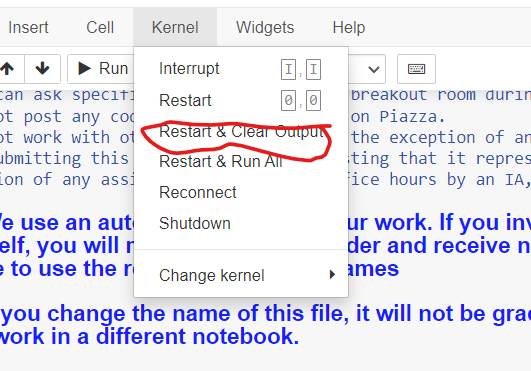